In [1]:
# ===============================================================
# CMSE 492 – Project: Predicting Exfoliation Energy of 2D Materials
# Author: Artemiy Filippov
# ===============================================================

# ===============================================================
# PART A: Setup and Imports
# ===============================================================

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matminer.datasets import load_dataset
from matminer.featurizers.structure import DensityFeatures
from matminer.featurizers.composition import ElementProperty

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import shap

# Directory setup
FIG_DIR = Path("../../figures")
DATA_DIR = Path("../../data")
PROC_DIR = DATA_DIR / "processed"
RAW_DIR = DATA_DIR / "raw"

for d in [FIG_DIR, PROC_DIR, RAW_DIR]:
    d.mkdir(parents=True, exist_ok=True)

sns.set(style="whitegrid", context="talk")

In [2]:
# ===============================================================
# PART B1: Load Dataset
# ===============================================================

df = load_dataset("matbench_jdft2d")
print(f"✅ Dataset loaded successfully: {df.shape[0]} samples, {df.shape[1]} columns")
display(df.head())

print("""
Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)
""")

# Save small raw sample
df.sample(50, random_state=42).to_csv(PROC_DIR / "sample_raw.csv", index=False)


# ===============================================================
# PART B2: Feature Generation
# ===============================================================

# Add composition column
df["composition"] = df["structure"].apply(lambda s: s.composition)

# Featurizers
density_feat = DensityFeatures()
magpie_feat = ElementProperty.from_preset("magpie")

# Apply featurization
df_feat = density_feat.featurize_dataframe(df.copy(), col_id="structure", ignore_errors=True)
df_feat = magpie_feat.featurize_dataframe(df_feat, col_id="composition", ignore_errors=True)

# Add target and clean
df_feat["exfoliation_en"] = df["exfoliation_en"].values
df_feat = df_feat.select_dtypes("number").dropna()

print("✅ Numeric features ready:", df_feat.shape)
display(df_feat.head())

# Save processed sample
df_feat.sample(50, random_state=0).to_csv(PROC_DIR / "sample_processed.csv", index=False)

✅ Dataset loaded successfully: 636 samples, 2 columns


,structure,exfoliation_en
0,"[[1.49323139 3.32688406 7.26257785] Hf, [3.326...",63.593833
1,"[[1.85068084 4.37698238 6.9301577 ] As, [0. ...",134.863750
2,"[[ 0. 2.0213325 11.97279555] Ti, [ 1...",43.114667
3,"[[2.39882726 2.39882726 2.53701553] In, [0.054...",240.715488
4,[[-1.83484554e-06 1.73300105e+00 2.61675943e...,67.442833



Dataset: MatBench JDFT-2D (Ward et al., 2020)
Source: Materials Project via Matminer
Target property: Exfoliation energy (eV/atom)



/opt/anaconda3/lib/python3.12/site-packages/matminer/utils/data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)


DensityFeatures:   0%|          | 0/636 [00:00<?, ?it/s]

ElementProperty:   0%|          | 0/636 [00:00<?, ?it/s]

✅ Numeric features ready: (635, 136)


,exfoliation_en,density,vpa,packing fraction,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData mode Number,...,MagpieData range GSmagmom,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mode GSmagmom,MagpieData minimum SpaceGroupNumber,MagpieData maximum SpaceGroupNumber,MagpieData range SpaceGroupNumber,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber,MagpieData mode SpaceGroupNumber
0,63.593833,3.021472,61.218660,0.177875,14.0,72.0,58.0,46.000000,21.333333,14.0,...,0.000000,0.000000,0.00000,0.0,152.0,227.0,75.0,191.000000,26.000000,152.0
1,134.863750,1.124487,110.637295,0.057581,33.0,33.0,0.0,33.000000,0.000000,33.0,...,0.000000,0.000000,0.00000,0.0,166.0,166.0,0.0,166.000000,0.000000,166.0
2,43.114667,1.385515,57.436271,0.108929,8.0,35.0,27.0,21.666667,9.111111,8.0,...,0.000023,0.000008,0.00001,0.0,12.0,194.0,182.0,90.000000,69.333333,12.0
3,240.715488,1.950268,137.847700,0.118812,49.0,83.0,34.0,66.000000,17.000000,49.0,...,0.000000,0.000000,0.00000,0.0,12.0,139.0,127.0,75.500000,63.500000,12.0
4,67.442833,1.183135,58.435112,0.083167,8.0,41.0,33.0,19.000000,14.666667,8.0,...,0.000000,0.000000,0.00000,0.0,12.0,229.0,217.0,84.333333,96.444444,12.0


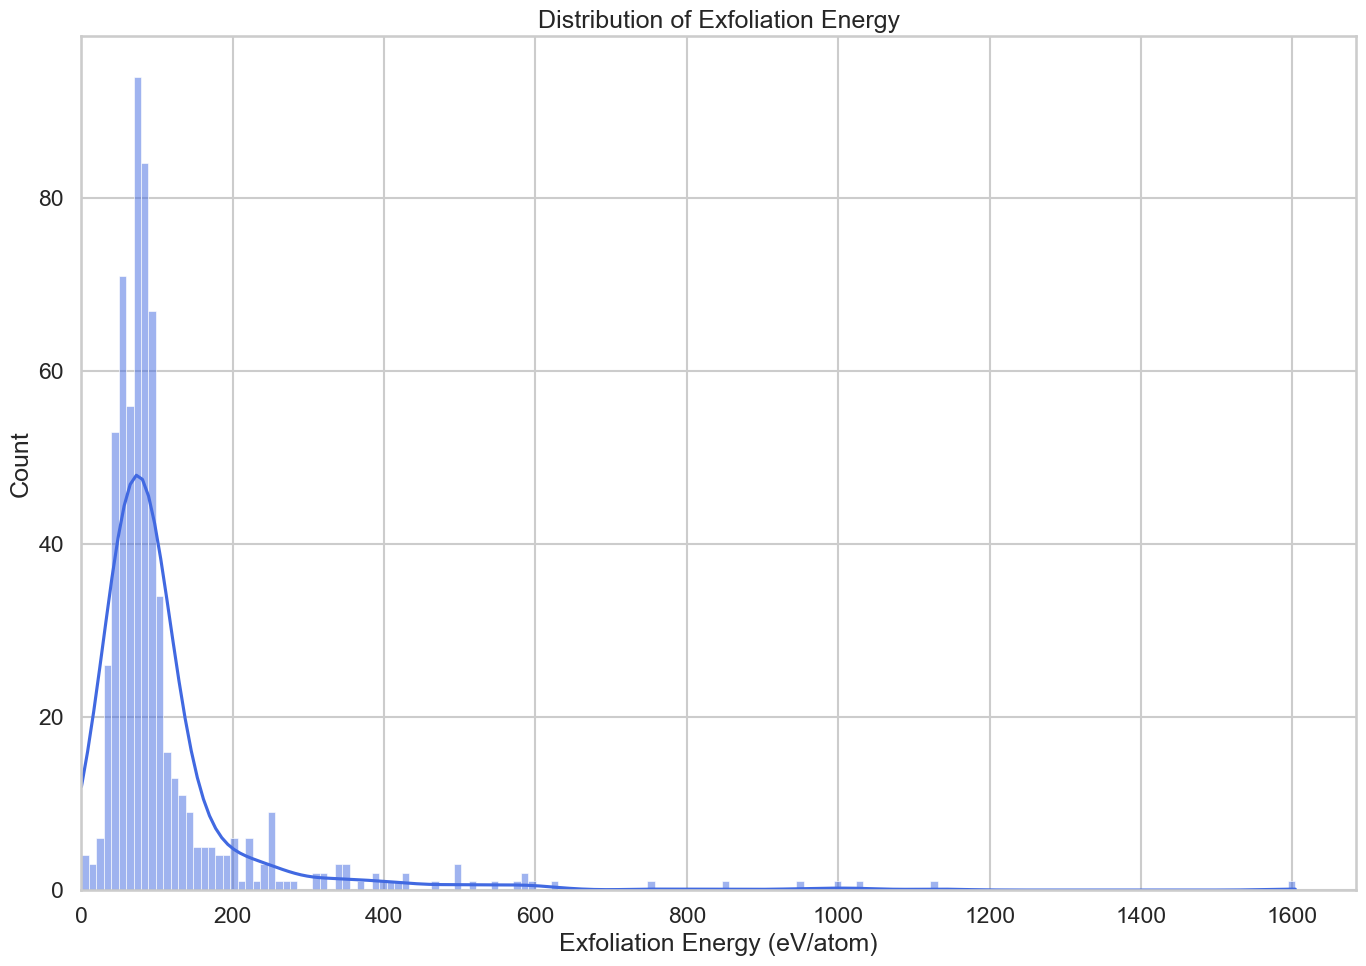

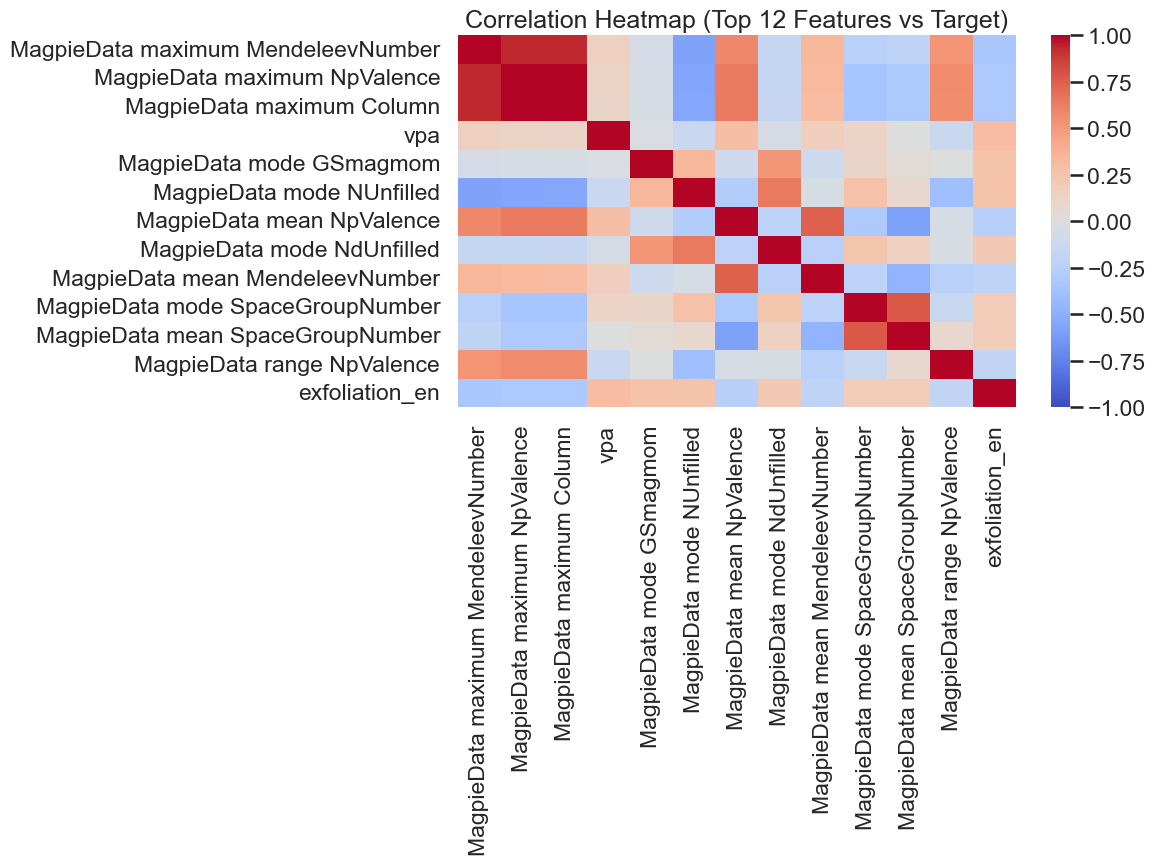

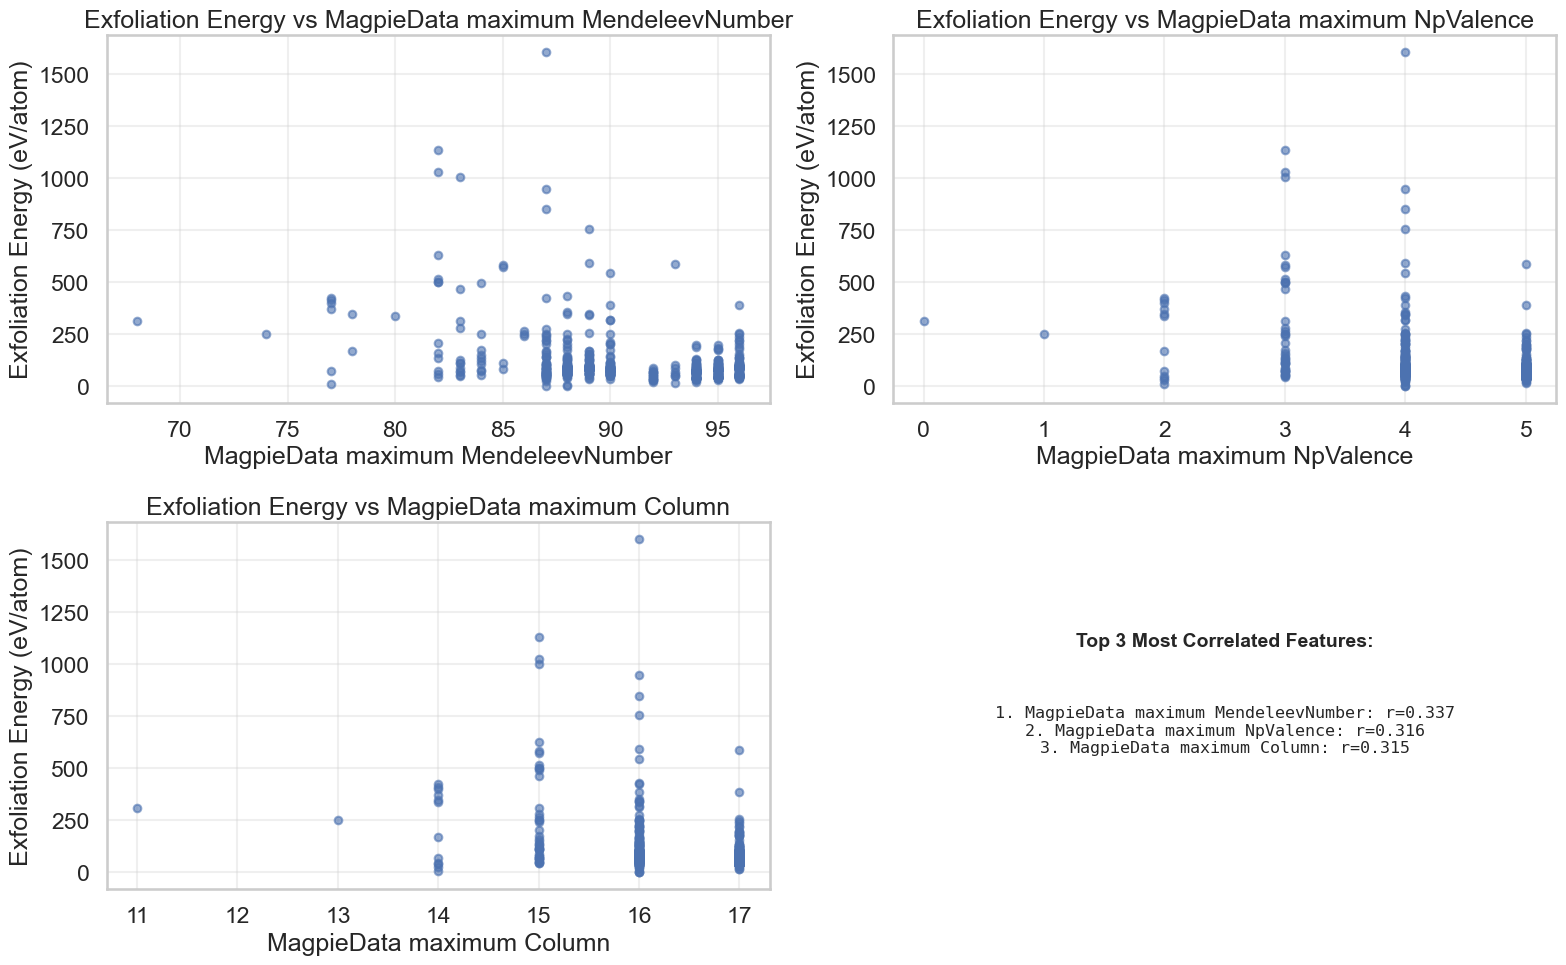


Top 10 Features Correlated with Exfoliation Energy:
 1. MagpieData maximum MendeleevNumber       |r| = 0.3367
 2. MagpieData maximum NpValence             |r| = 0.3161
 3. MagpieData maximum Column                |r| = 0.3147
 4. vpa                                      |r| = 0.3124
 5. MagpieData mode GSmagmom                 |r| = 0.2626
 6. MagpieData mode NUnfilled                |r| = 0.2613
 7. MagpieData mean NpValence                |r| = 0.2519
 8. MagpieData mode NdUnfilled               |r| = 0.2138
 9. MagpieData mean MendeleevNumber          |r| = 0.2105
10. MagpieData mode SpaceGroupNumber         |r| = 0.1901


In [3]:
# ===============================================================
# PART C1: Exploratory Data Analysis - Target Distribution
# ===============================================================

plt.figure(figsize=(14,10))
sns.histplot(df_feat["exfoliation_en"], kde=True, color="royalblue")
plt.xlabel("Exfoliation Energy (eV/atom)")
plt.ylabel("Count")
plt.title("Distribution of Exfoliation Energy")
plt.xlim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "exfoliation_distribution.png", dpi=300)
plt.show()

# ===============================================================
# PART C2: Exploratory Data Analysis - Correlation Heatmap
# ===============================================================

# Correlation heatmap (top correlated features)
corr = df_feat.corr(numeric_only=True)
target_corr = corr["exfoliation_en"].drop("exfoliation_en").abs().sort_values(ascending=False)
top_feats = list(target_corr.head(12).index) + ["exfoliation_en"]

plt.figure(figsize=(12,9))
sns.heatmap(df_feat[top_feats].corr(), cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Correlation Heatmap (Top 12 Features vs Target)")
plt.tight_layout()
plt.savefig(FIG_DIR / "feature_correlation_heatmap.png", dpi=300)
plt.show()

# ===============================================================
# PART C3: Exploratory Data Analysis - Key Feature Relationships
# ===============================================================

# Create a 2x2 grid showing relationships with top 3 features
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Top 3 correlated features
top_3_features = list(target_corr.head(3).index)

for idx, feature in enumerate(top_3_features):
    row = idx // 2
    col = idx % 2
    axes[row, col].scatter(df_feat[feature], df_feat["exfoliation_en"], alpha=0.6, s=30)
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel("Exfoliation Energy (eV/atom)")
    axes[row, col].set_title(f"Exfoliation Energy vs {feature}")
    axes[row, col].grid(True, alpha=0.3)

# Use the 4th subplot for a summary
axes[1, 1].axis('off')
axes[1, 1].text(0.5, 0.7, 'Top 3 Most Correlated Features:', 
                ha='center', va='top', fontsize=14, fontweight='bold')
summary_text = '\n'.join([f"{i+1}. {feat}: r={target_corr[feat]:.3f}" 
                          for i, feat in enumerate(top_3_features)])
axes[1, 1].text(0.5, 0.5, summary_text, ha='center', va='top', 
                fontsize=12, family='monospace')

plt.tight_layout()
plt.savefig(FIG_DIR / "top_features_vs_target.png", dpi=300)
plt.show()

# Print feature statistics
print("\nTop 10 Features Correlated with Exfoliation Energy:")
print("="*60)
for i, (feat, corr_val) in enumerate(target_corr.head(10).items(), 1):
    print(f"{i:2d}. {feat:40s} |r| = {corr_val:.4f}")



BASELINE MODEL: LINEAR REGRESSION
CV MAE:  73.537 ± 8.542 eV/atom
CV RMSE: 130.625 ± 26.520 eV/atom
Test MAE:  61.681 eV/atom
Test RMSE: 92.576 eV/atom


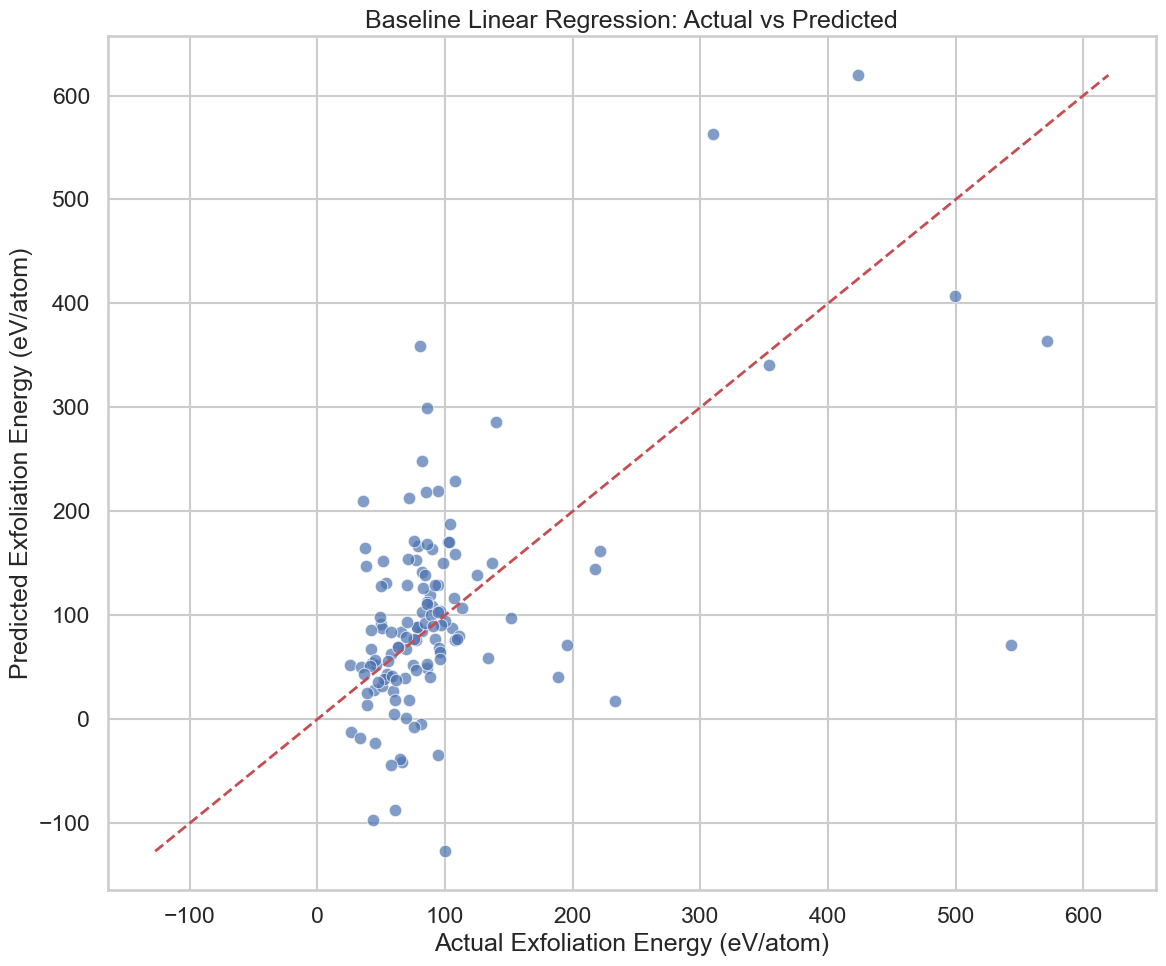

In [4]:
# ===============================================================
# PART D: Baseline Model - Linear Regression
# ===============================================================

print("\n" + "="*70)
print("BASELINE MODEL: LINEAR REGRESSION")
print("="*70)

X = df_feat.drop(columns=["exfoliation_en"])
y = df_feat["exfoliation_en"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaled pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

# Cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mae = -cross_val_score(pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse = np.sqrt(-cross_val_score(pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"CV MAE:  {cv_mae.mean():.3f} ± {cv_mae.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse.mean():.3f} ± {cv_rmse.std():.3f} eV/atom")

# Train/test metrics
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test MAE:  {mae:.3f} eV/atom")
print(f"Test RMSE: {rmse:.3f} eV/atom")

# Actual vs Predicted
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Baseline Linear Regression: Actual vs Predicted")
plt.tight_layout()
plt.savefig(FIG_DIR / "baseline_actual_vs_predicted.png", dpi=300)
plt.show()


RANDOM FOREST REGRESSOR
CV MAE:  44.438 ± 8.561 eV/atom
CV RMSE: 106.757 ± 34.676 eV/atom
Test MAE:  31.816 eV/atom
Test RMSE: 63.035 eV/atom
Improvement vs baseline: 48.4%


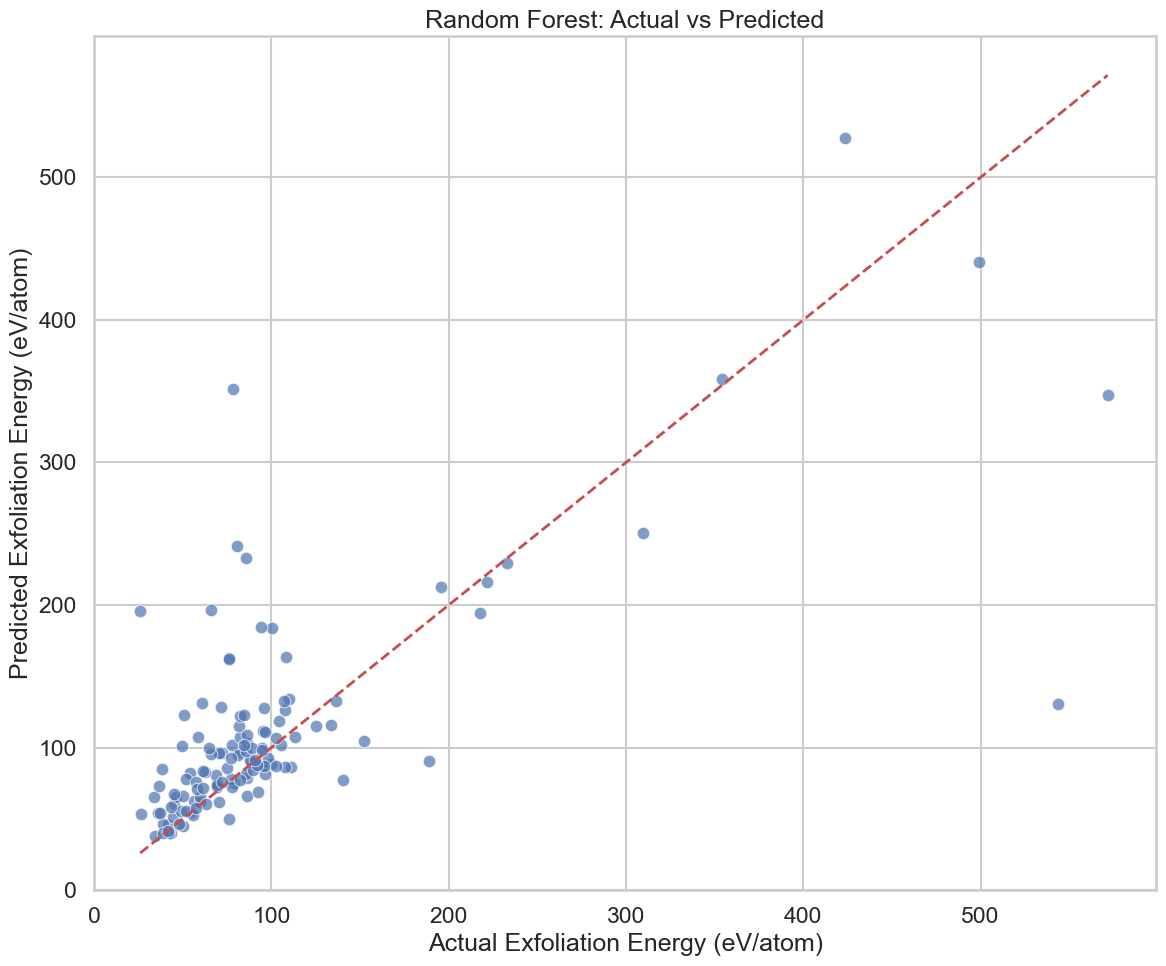

In [5]:
# ===============================================================
# PART E: Random Forest Model
# ===============================================================

print("\n" + "="*70)
print("RANDOM FOREST REGRESSOR")
print("="*70)

# Train Random Forest
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

rf_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf_model)
])

# Cross-validation
cv_mae_rf = -cross_val_score(rf_pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse_rf = np.sqrt(-cross_val_score(rf_pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"CV MAE:  {cv_mae_rf.mean():.3f} ± {cv_mae_rf.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse_rf.mean():.3f} ± {cv_rmse_rf.std():.3f} eV/atom")

# Train and test
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Test MAE:  {rf_mae:.3f} eV/atom")
print(f"Test RMSE: {rf_rmse:.3f} eV/atom")
print(f"Improvement vs baseline: {((mae - rf_mae) / mae * 100):.1f}%")

# Actual vs Predicted
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.7)
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Random Forest: Actual vs Predicted")
plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "rf_predictions.png", dpi=300)
plt.show()


NEURAL NETWORK (MLP)
🔍 Tuning neural network hyperparameters...
   (This will take 2-3 minutes...)
Fitting 5 folds for each of 15 candidates, totalling 75 fits

✅ Best hyperparameters found:
   nn__learning_rate_init: 0.005
   nn__hidden_layer_sizes: (128, 64, 32)
   nn__batch_size: 32
   nn__alpha: 0.0001

CV MAE:  49.694 ± 3.607 eV/atom
CV RMSE: 121.216 ± 22.910 eV/atom

Test MAE:  43.774 eV/atom
Test RMSE: 80.030 eV/atom
Improvement vs baseline: 29.0%


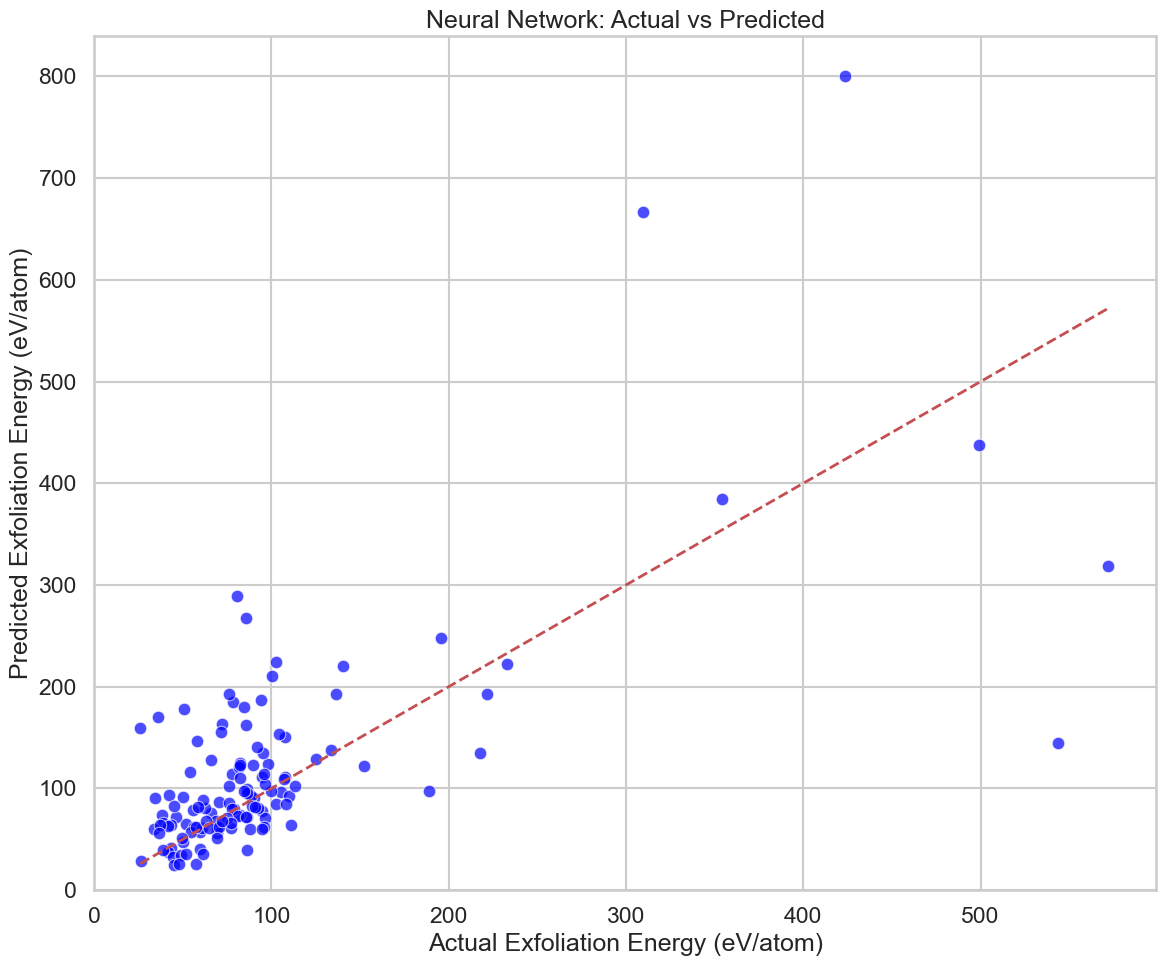

In [6]:
# ===============================================================
# PART F: Neural Network Model
# ===============================================================

print("\n" + "="*70)
print("NEURAL NETWORK (MLP)")
print("="*70)

from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_dist = {
    'nn__hidden_layer_sizes': [
        (256, 128, 64),
        (512, 256, 128),
        (256, 128),
        (384, 192, 96),
        (128, 64, 32)
    ],
    'nn__alpha': [0.0001, 0.001, 0.01, 0.05],
    'nn__learning_rate_init': [0.0001, 0.0005, 0.001, 0.005],
    'nn__batch_size': [32, 64],
}

# Base model with better defaults
nn_model = MLPRegressor(
    activation='relu',
    solver='adam',
    max_iter=2000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=50,
    random_state=42,
    verbose=False
)

nn_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("nn", nn_model)
])

# Randomized search
print("🔍 Tuning neural network hyperparameters...")
print("   (This will take 2-3 minutes...)")

search = RandomizedSearchCV(
    nn_pipe,
    param_dist,
    n_iter=15,
    cv=5,
    scoring='neg_mean_absolute_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

search.fit(X_train, y_train)

print(f"\n✅ Best hyperparameters found:")
for param, value in search.best_params_.items():
    print(f"   {param}: {value}")

# Use best model
nn_pipe = search.best_estimator_

# Cross-validation
cv_mae_nn = -cross_val_score(nn_pipe, X, y, scoring="neg_mean_absolute_error", cv=cv)
cv_rmse_nn = np.sqrt(-cross_val_score(nn_pipe, X, y, scoring="neg_mean_squared_error", cv=cv))

print(f"\nCV MAE:  {cv_mae_nn.mean():.3f} ± {cv_mae_nn.std():.3f} eV/atom")
print(f"CV RMSE: {cv_rmse_nn.mean():.3f} ± {cv_rmse_nn.std():.3f} eV/atom")

# Test predictions
y_pred_nn = nn_pipe.predict(X_test)

nn_mae = mean_absolute_error(y_test, y_pred_nn)
nn_rmse = np.sqrt(mean_squared_error(y_test, y_pred_nn))

print(f"\nTest MAE:  {nn_mae:.3f} eV/atom")
print(f"Test RMSE: {nn_rmse:.3f} eV/atom")
print(f"Improvement vs baseline: {((mae - nn_mae) / mae * 100):.1f}%")

# Plot
plt.figure(figsize=(12,10))
sns.scatterplot(x=y_test, y=y_pred_nn, alpha=0.7, color='blue')
lims = [y_test.min(), y_test.max()]
plt.plot(lims, lims, "r--", lw=2)
plt.xlabel("Actual Exfoliation Energy (eV/atom)")
plt.ylabel("Predicted Exfoliation Energy (eV/atom)")
plt.title("Neural Network: Actual vs Predicted")
plt.xlim(0)
plt.ylim(0)
plt.tight_layout()
plt.savefig(FIG_DIR / "nn_predictions.png", dpi=300)
plt.show()


MODEL COMPARISON

            Model  Test MAE  Test RMSE
Linear Regression 61.681007  92.575736
    Random Forest 31.816246  63.034881
   Neural Network 43.773682  80.030215

Best model: Random Forest


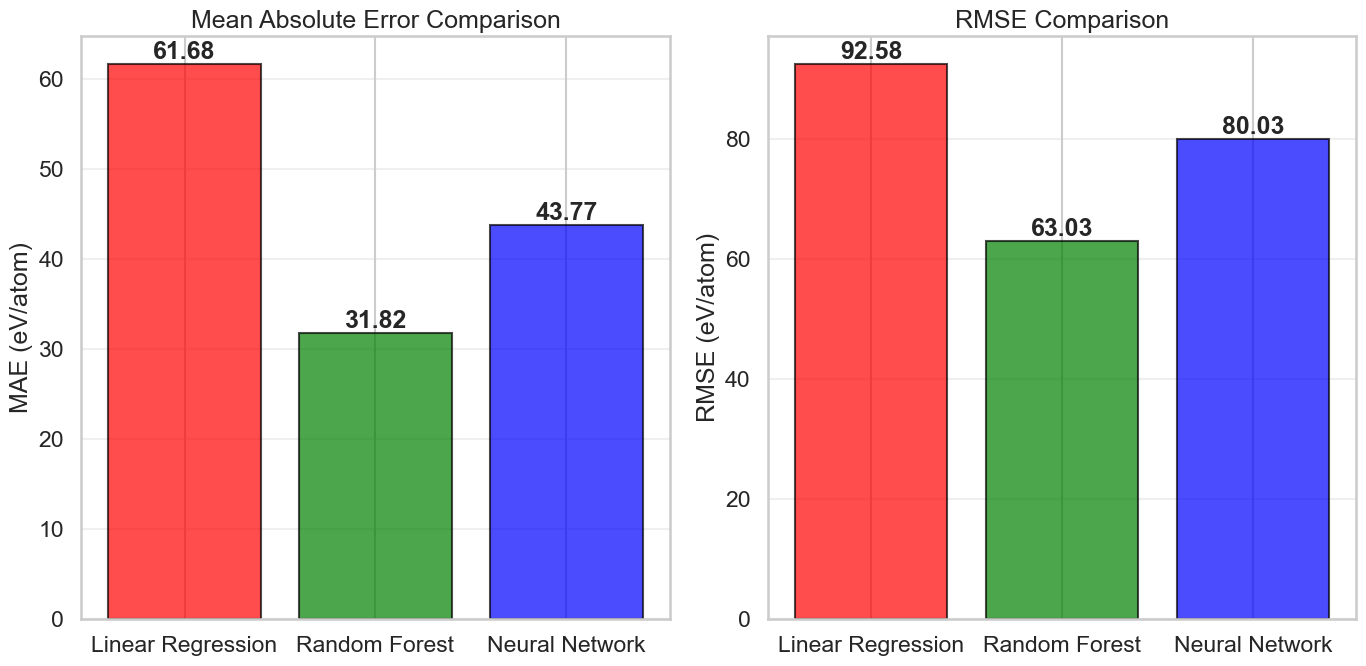

In [7]:
# ===============================================================
# PART G1: Model Comparison
# ===============================================================

print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

# Summary table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Neural Network'],
    'Test MAE': [mae, rf_mae, nn_mae],
    'Test RMSE': [rmse, rf_rmse, nn_rmse]
})

print("\n" + results.to_string(index=False))
print(f"\nBest model: {results.loc[results['Test MAE'].idxmin(), 'Model']}")

# Bar plot
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# MAE comparison
models = results['Model'].tolist()
maes = results['Test MAE'].tolist()
colors = ['red', 'green', 'blue']

axes[0].bar(models, maes, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('MAE (eV/atom)')
axes[0].set_title('Mean Absolute Error Comparison')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(maes):
    axes[0].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

# RMSE comparison
rmses = results['Test RMSE'].tolist()
axes[1].bar(models, rmses, color=colors, alpha=0.7, edgecolor='black')
axes[1].set_ylabel('RMSE (eV/atom)')
axes[1].set_title('RMSE Comparison')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(rmses):
    axes[1].text(i, v, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(FIG_DIR / "model_comparison.png", dpi=300)
plt.show()

# Save results
results.to_csv(PROC_DIR / "model_comparison.csv", index=False)


SHAP ANALYSIS


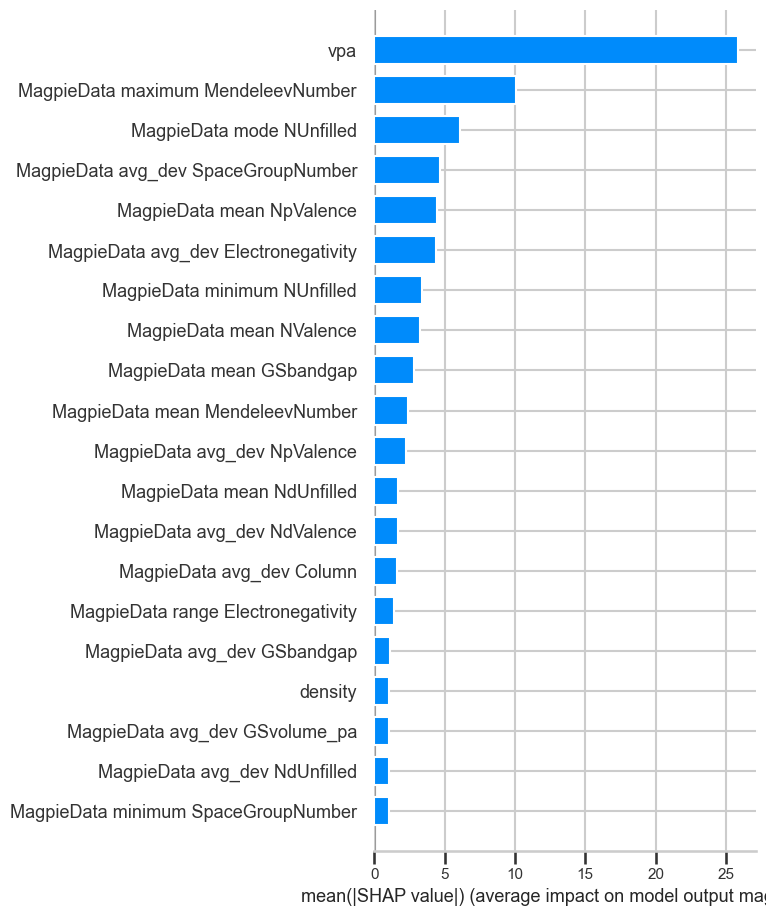

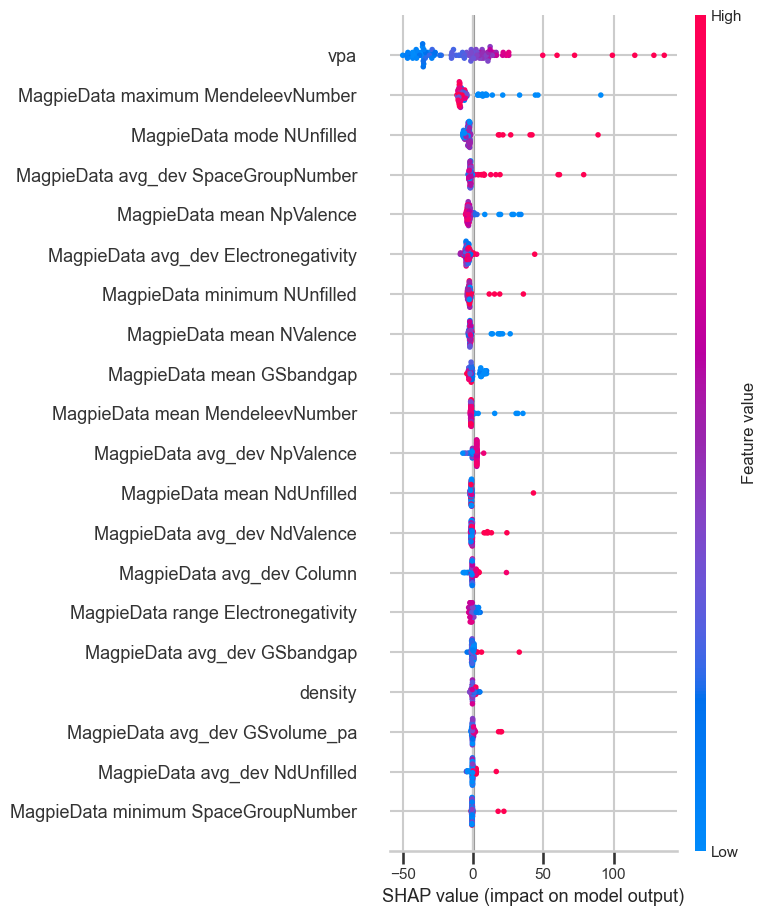

In [8]:
# ===============================================================
# PART G2: SHAP Analysis
# ===============================================================

print("\n" + "="*70)
print("SHAP ANALYSIS")
print("="*70)

# Use a subset for speed
X_shap = X_test.sample(n=100, random_state=42)

# Create explainer
explainer = shap.TreeExplainer(rf_pipe.named_steps['rf'])
X_shap_scaled = rf_pipe.named_steps['scaler'].transform(X_shap)
shap_values = explainer.shap_values(X_shap_scaled)

# Summary plot (bar)
plt.figure(figsize=(30, 6))
shap.summary_plot(shap_values, X_shap, plot_type="bar", show=False)
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_importance.png", dpi=300)
plt.show()

# Detailed summary (beeswarm)
plt.figure(figsize=(30, 6))
shap.summary_plot(shap_values, X_shap, show=False)
plt.tight_layout()
plt.savefig(FIG_DIR / "shap_summary.png", dpi=300)
plt.show()

In [9]:
# ===============================================================
# PART G3: Final Summary
# ===============================================================

print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)

print(f"\nDataset: MatBench JDFT-2D ({len(df_feat)} samples)")
print(f"Features: {len(X.columns)} compositional + structural descriptors")
print(f"\nResults:")
print(f"  Baseline (Linear):  MAE = {mae:.3f} eV/atom")
print(f"  Random Forest:      MAE = {rf_mae:.3f} eV/atom ({((mae-rf_mae)/mae*100):.1f}% better)")
print(f"  Neural Network:     MAE = {nn_mae:.3f} eV/atom ({((mae-nn_mae)/mae*100):.1f}% better)")
print(f"\n✅ Project complete! All figures saved to {FIG_DIR}")
print("="*70)


FINAL SUMMARY

Dataset: MatBench JDFT-2D (635 samples)
Features: 135 compositional + structural descriptors

Results:
  Baseline (Linear):  MAE = 61.681 eV/atom
  Random Forest:      MAE = 31.816 eV/atom (48.4% better)
  Neural Network:     MAE = 43.774 eV/atom (29.0% better)

✅ Project complete! All figures saved to ../../figures
